In [1]:
# import libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
# read the data

UK_customers_data = pd.read_pickle("../data/UK_customers_rfm.pkl")

# preview the data

UK_customers_data.head(n = 3)

,Frequency,Monetary,Recency
CustomerID,,,
u12346,1,77183.60,325
u12747,11,3763.01,1
u12748,202,28308.44,0


In [3]:
# check shape

UK_customers_data.head()

,Frequency,Monetary,Recency
CustomerID,,,
u12346,1,77183.60,325
u12747,11,3763.01,1
u12748,202,28308.44,0
u12749,5,2720.63,3
u1282,4,942.34,2


In [3]:
# check structure of data

UK_customers_data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3891 entries, u12346 to u18287
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Frequency  3891 non-null   int64  
 1   Monetary   3891 non-null   float64
 2   Recency    3891 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 121.6+ KB


In [4]:
# check for missing data

UK_customers_data.isnull().sum()

# we have no categorical data, no missing data, no feature engineering required at this stage

Frequency    0
Monetary     0
Recency      0
dtype: int64

In [5]:
# let's check for duplicates

print("# of duplicated rows of data:", 
      UK_customers_data[UK_customers_data.duplicated(keep = False)].shape[0])


# of duplicated rows of data: 2


In [6]:
# look at duplicated values

UK_customers_data[UK_customers_data.duplicated(keep = False)]


,Frequency,Monetary,Recency
CustomerID,,,
u16406,1,155.12,18
u17561,1,155.12,18


In [7]:
# we can either drop all duplicated data, or keep the first or last row


UK_customers_data_cleaned = UK_customers_data[~UK_customers_data.duplicated(keep = 'first')]
print("shape of cleaned data:", UK_customers_data_cleaned.shape)


shape of cleaned data: (3890, 3)


In [8]:
# do some exploratory work - look at distribution of the data

UK_customers_data_cleaned.describe()

# monetary in a different scale than frequency and recency

,Frequency,Monetary,Recency
count,3890.000000,3890.000000,3890.000000
mean,4.193830,1625.729674,90.887661
std,7.045783,6745.629029,99.399720
min,1.000000,0.000000,0.000000
25%,1.000000,243.515000,17.000000
50%,2.000000,548.570000,49.500000
75%,5.000000,1369.762500,140.750000
max,202.000000,221190.810000,373.000000


In [9]:
# cluster the customer data

# step 1: scale the data

scaler = StandardScaler()

scaler.fit(UK_customers_data_cleaned)

UK_customers_scaled = scaler.transform(UK_customers_data_cleaned)
print('New std deviation:', UK_customers_scaled.std())
print('New mean:', round(UK_customers_scaled.mean()))

# normalized data has a mean of 0 and std of 1

New std deviation: 1.0
New mean: 0


In [18]:
UK_customers_scaled

array([[-4.53354998e-01,  1.12024518e+01,  2.35556434e+00],
       [ 9.66116141e-01,  3.16880025e-01, -9.04421221e-01],
       [ 2.80780149e+01,  3.95606407e+00, -9.14482905e-01],
       ...,
       [-3.11407884e-01, -2.22199047e-01, -8.44051119e-01],
       [ 1.67585171e+00,  6.23150721e-02, -8.84297854e-01],
       [-1.69460770e-01,  2.63241798e-02, -4.91892185e-01]])

In [10]:
# step 2: identify optimal number of clusters we want to segment the data

def optimal_number_clusters(data_scaled):
    """
    Calculates optimal number of clusted based on Elbow Method
    
    parameters: scaled data
    """
    Sum_of_squared_distances = []
    K = range(1, 30) # define the range of clusters we would like to cluster the data into

    for k in K:
        km = KMeans(n_clusters = k)
        km = km.fit(data_scaled)
        Sum_of_squared_distances.append(km.inertia_)

    plt.figure(figsize=(20,6))

    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

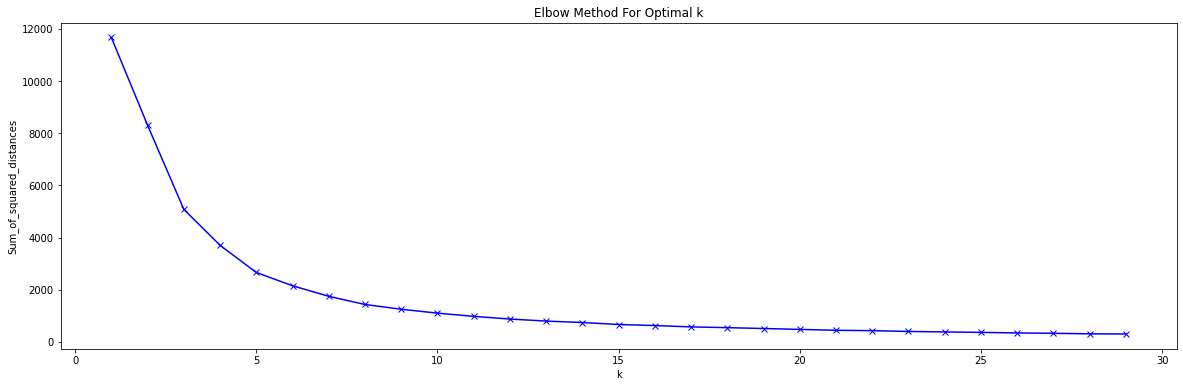

In [11]:
optimal_number_clusters(UK_customers_scaled)

# Question: Where is the elbow forming? Or where we are we saying the least amount of change
# identifying clusters: https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb

In [12]:
# THE MACHINE LEARNING ALGORITHM

n_clusters = 4 # define the number of clusters, where the elbow if formed

kmeans = KMeans(n_clusters = n_clusters, random_state = 10) # initialize the k-means function
kmeans.fit(UK_customers_scaled) # fit to the summary scaled data

KMeans(n_clusters=4, random_state=10)

In [13]:
# predict the clusters for the users

y_kmeans = kmeans.predict(UK_customers_scaled)

# or y_kmeans = kmeans.labels_

In [14]:
y_kmeans

array([3, 1, 3, ..., 1, 1, 1], dtype=int32)

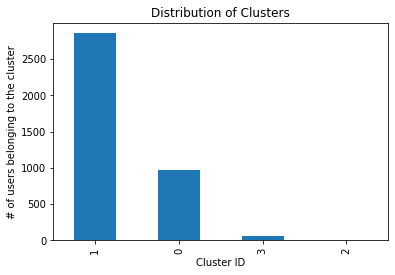

In [15]:
# check the distribution of the clusters

pd.DataFrame(Counter(y_kmeans).most_common()).set_index(0).plot.bar(legend=None)
plt.title('Distribution of Clusters')
plt.xlabel('Cluster ID')
plt.ylabel('# of users belonging to the cluster');

# results dont look amazing, might need to do some outlier removal or remove scaling.
# However, will evaluate this in more detail before defining steps.

In [16]:
print("The centroids for the clusters")

pd.DataFrame(kmeans.cluster_centers_, columns = UK_customers_data_cleaned.columns)


The centroids for the clusters


,Frequency,Monetary,Recency
0,-0.371429,-0.185888,1.540123
1,0.015876,-0.040260,-0.507281
2,4.183584,27.956844,-0.891006
3,5.137918,3.589731,-0.771743


In [17]:
# join this to our data frame

results = pd.DataFrame(UK_customers_data_cleaned.copy())
results.insert(3, 'cluster', y_kmeans)
results.head()

# the customers and their assigned clusters

,Frequency,Monetary,Recency,cluster
CustomerID,,,,
u12346,1,77183.60,325,3
u12747,11,3763.01,1,1
u12748,202,28308.44,0,3
u12749,5,2720.63,3,1
u1282,4,942.34,2,1


In [24]:
results.cluster.value_counts()

1    2856
0     972
3      59
2       3
Name: cluster, dtype: int64

In [25]:
# evaluate the clusters
# What does the smallest group look like

results[results.cluster == 2].describe()

# could be a bulk order customer - high volumes, high amounts

,Frequency,Monetary,Recency,cluster
count,3.000000,3.000000,3.000000,3.0
mean,33.666667,190187.986667,2.333333,2.0
std,28.183920,27558.955334,4.041452,0.0
min,2.000000,168472.500000,0.000000,2.0
25%,22.500000,174686.575000,0.000000,2.0
50%,43.000000,180900.650000,0.000000,2.0
75%,49.500000,201045.730000,3.500000,2.0
max,56.000000,221190.810000,7.000000,2.0


In [26]:
# what does largest largest group look like

results[results.cluster == 1].describe()

# on average spend 1.3k, and 4 purchases


,Frequency,Monetary,Recency,cluster
count,2856.000000,2856.000000,2856.000000,2856.0
mean,4.305672,1354.188478,40.470588,1.0
std,4.120690,1779.863791,35.104565,0.0
min,1.000000,0.000000,0.000000,1.0
25%,2.000000,328.952500,12.000000,1.0
50%,3.000000,736.550000,30.000000,1.0
75%,5.000000,1702.092500,63.000000,1.0
max,28.000000,25755.330000,162.000000,1.0


In [27]:
# what does group 0 look like

results[results.cluster == 0].describe()

# on average spend 300 and around 1 to 2 orders. This is our lowest value customer group.


,Frequency,Monetary,Recency,cluster
count,972.000000,972.000000,972.000000,972.0
mean,1.577160,371.958087,243.955761,0.0
std,1.500845,481.597320,66.927810,0.0
min,1.000000,4.250000,137.000000,0.0
25%,1.000000,136.575000,185.750000,0.0
50%,1.000000,244.105000,239.000000,0.0
75%,2.000000,405.570000,295.000000,0.0
max,34.000000,6667.670000,373.000000,0.0


In [28]:
# what does group 3 look like

results[results.cluster == 3].describe()

# similar behaviour to smallest group. Might just be three pure clusters.


,Frequency,Monetary,Recency,cluster
count,59.000000,59.000000,59.000000,59.0
mean,40.389831,25837.608814,14.186441,3.0
std,30.572704,19992.315417,51.308558,0.0
min,1.000000,856.980000,0.000000,3.0
25%,26.500000,11191.620000,1.000000,3.0
50%,31.000000,17501.540000,3.000000,3.0
75%,44.500000,35797.575000,7.500000,3.0
max,202.000000,85922.000000,325.000000,3.0


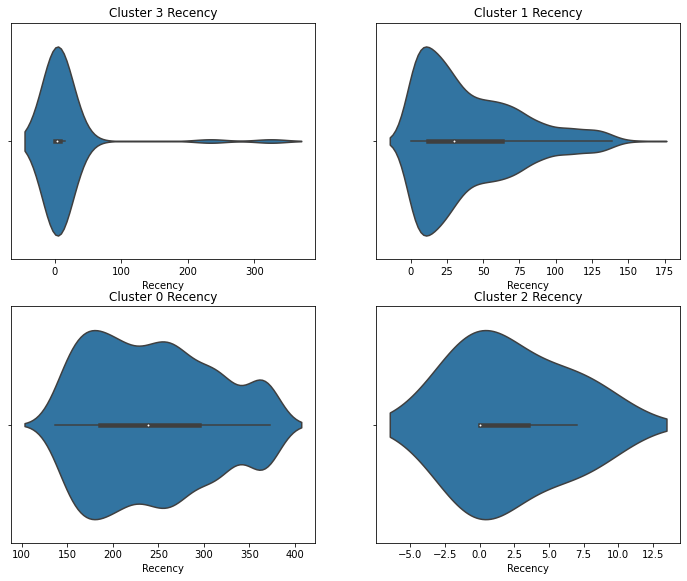

In [29]:
# recency plots

clusters = results["cluster"].unique() 

x = 1
plt.figure(figsize=(12, 20))
for x, c in enumerate(clusters):
    ax = plt.subplot(4, 2, x + 1)
    plt.title(f'Cluster {c} Recency')
    sns.violinplot(x=results[results["cluster"] == c].Recency);


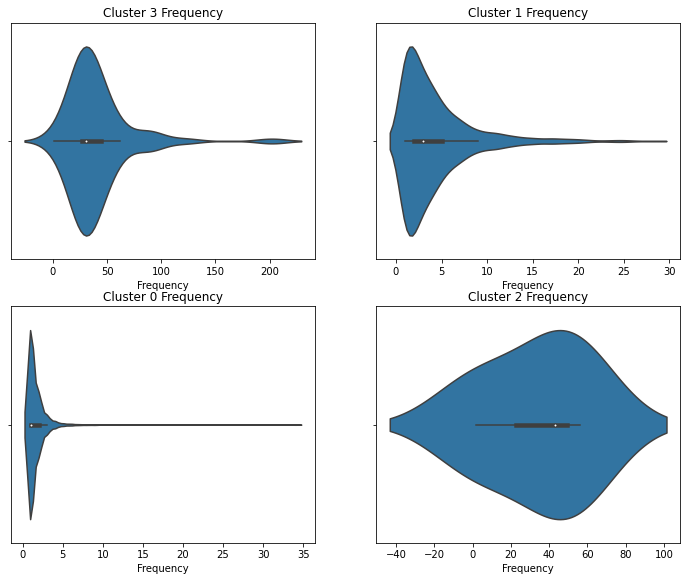

In [30]:
clusters = results["cluster"].unique() 

x = 1
plt.figure(figsize=(12, 20))
for x, c in enumerate(clusters):
    ax = plt.subplot(4, 2, x + 1)
    plt.title(f'Cluster {c} Frequency')
    sns.violinplot(x=results[results["cluster"] == c].Frequency);


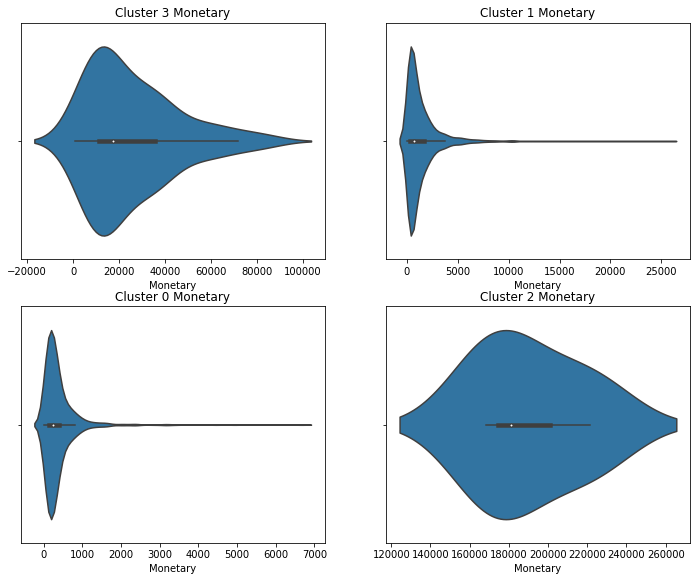

In [31]:
clusters = results["cluster"].unique() 

x = 1
plt.figure(figsize=(12, 20))
for x, c in enumerate(clusters):
    ax = plt.subplot(4, 2, x + 1)
    plt.title(f'Cluster {c} Monetary')
    sns.violinplot(x=results[results["cluster"] == c].Monetary);


In [ ]:
# Smallest group the most valuable group. 
# We may want to take the customers identified in largest cluster, and cluster again to find smaller clusters.
# Each group varies according to R, F and M. 
# Need to come up with different strategies for different groups.

In [21]:
from sklearn.decomposition import PCA


def visualize(y_kmeans, data_scaled, n_clusters):
    """
       Visualize the users with predicted clusters.
        
       Run PCA on the transposed data and reduce the dimnensions in pca_num_components dimensions
        
     """
        
    reduced_data = PCA(n_components = 2).fit_transform(data_scaled)
    results = pd.DataFrame(reduced_data, columns = ['pca1','pca2'])
    results = pd.concat([results, pd.DataFrame(y_kmeans)], axis = 1).rename(columns={0 : "cluster"})

    cmap = sns.color_palette("Set1", n_colors = n_clusters, desat = .5)

    sns.scatterplot(x = 'pca1', y = 'pca2', hue = 'cluster', data = results, palette = cmap, legend = True)
    plt.title('K-means Clustering with 2 dimensions')
    plt.show();
        

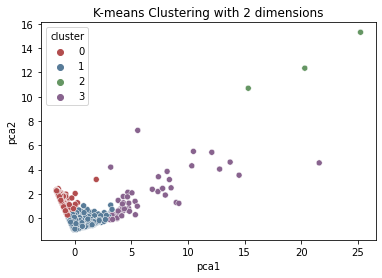

In [22]:
# visualising the pattern of the clusters
# only for visualisation purposes

visualize(y_kmeans, UK_customers_scaled, n_clusters=n_clusters)

# the clusters more spread out have more variability